<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/gpt-neo/661_GPT_Neo_CARER_FSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-Neo CARER
This notebook will prompt a pretrained GPT-Neo on the Contextualized Affect Representations for Emotion Recognition (CARER) dataset via Few Shot Prompting.

## Setup

In [1]:
!pip install datasets transformers torch scikit-learn matplotlib seaborn

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Dataset and Model

In [2]:
dataset = load_dataset("dair-ai/emotion", split="test")
model_name = "EleutherAI/gpt-neo-2.7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

## Evaluation

### One example per emotion

In [3]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = (f"Choose which emotion this text expresses from the following options: {','.join(emotions)}.\n\n"

              "Text: 'im feel alone and i dont know how to cope'\n"
              "The emotion that best describes this text is: sadness\n\n"

              "Text: 'i didnt want to tell him because arun has these single line solutions to all my problems that leave me feeling extremely dissatisfied'\n"
              "The emotion that best describes this text is: anger\n\n"

              "Text: 'i just had this feeling that i liked him more'\n"
              "The emotion that best describes this text is: love\n\n"

              "Text: 'i had a hard time focusing on my life and walked around feeling dazed and confused'\n"
              "The emotion that best describes this text is: surprise\n\n"

              "Text: 'i realized that when i let my mind race and i start to feel restless i get the desire to smoke'\n"
              "The emotion that best describes this text is: fear\n\n"

              "Text: 'i feel cool calm and collected'\n"
              "The emotion that best describes this text is: joy\n\n"

              f"Text: '{text}'.\n"
              "The emotion that best describes this text is:"
              )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

print("Sample Results from the Dataset:\n")
for i in range(5):
    review = dataset[i]["text"]
    true_label = dataset[i]["label"]
    predicted_emotion = classify_review(review)
    print(f"Review: {review}")
    print(f"True Emotion: {emotions[true_label]}")  # Convert label to emotion name
    print(f"Classified as: {predicted_emotion}\n")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Sample Results from the Dataset:

Review: im feeling rather rotten so im not very ambitious right now
True Emotion: sadness
Classified as: surprise

Review: im updating my blog because i feel shitty
True Emotion: sadness
Classified as: love

Review: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Emotion: sadness
Classified as: love

Review: i left with my bo

Few-shot accuracy on the CARER dataset: 14.70%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.75      0.01      0.01       581
         joy       0.93      0.02      0.04       695
        love       0.11      0.92      0.19       159
       anger       0.43      0.40      0.41       275
        fear       0.00      0.00      0.00       224
    surprise       0.06      0.30      0.10        66

    accuracy                           0.15      2000
   macro avg       0.38      0.28      0.13      2000
weighted avg       0.61      0.15      0.09      2000



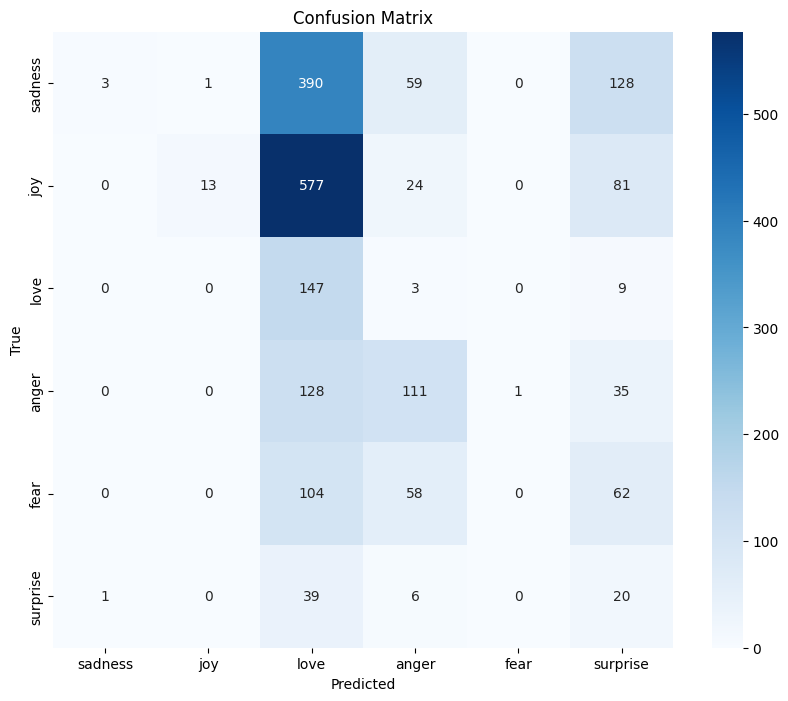

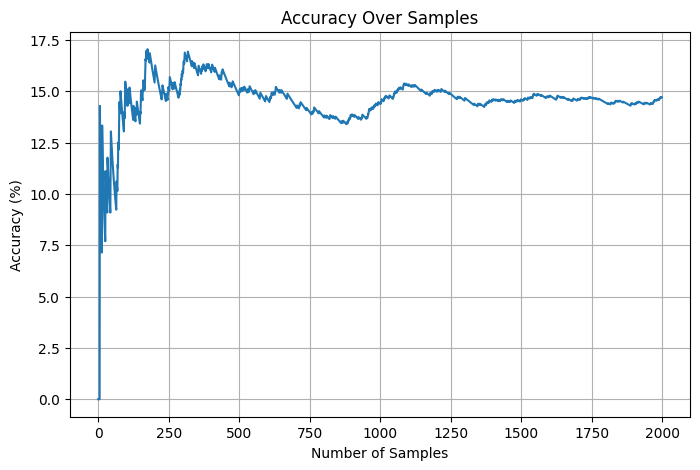

In [4]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Few-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

### Two example per emotion

In [ ]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = (f"Choose which emotion this text expresses from the following options: {','.join(emotions)}.\n\n"

              "Text: 'im feel alone and i dont know how to cope'\n"
              "The emotion that best describes this text is: sadness\n\n"

              "Text: 'im feeling rather rotten so im not very ambitious right now'\n"
              "The emotion that best describes this text is: sadness\n\n"

              "Text: 'i didnt want to tell him because arun has these single line solutions to all my problems that leave me feeling extremely dissatisfied'\n"
              "The emotion that best describes this text is: anger\n\n"

              "Text: 'i feel really angry sometimes because for the love of god havent we been through enough'\n"
              "The emotion that best describes this text is: anger\n\n"

              "Text: 'i just had this feeling that i liked him more'\n"
              "The emotion that best describes this text is: love\n\n"

              "Text: 'ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures'\n"
              "The emotion that best describes this text is: love\n\n"

              "Text: 'i watch her silently feeling dazed from my memory loss'\n"
              "The emotion that best describes this text is: surprise\n\n"

              "Text: 'i had a hard time focusing on my life and walked around feeling dazed and confused'\n"
              "The emotion that best describes this text is: surprise\n\n"

              "Text: 'i realized that when i let my mind race and i start to feel restless i get the desire to smoke'\n"
              "The emotion that best describes this text is: fear\n\n"

              "Text: 'i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted'\n"
              "The emotion that best describes this text is: fear\n\n"

              "Text: 'i feel cool calm and collected'\n"
              "The emotion that best describes this text is: joy\n\n"

              "Text: 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'\n"
              "The emotion that best describes this text is: joy\n\n"

              f"Text: '{text}'.\n"
              "The emotion that best describes this text is:"
              )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

print("Sample Results from the Dataset:\n")
for i in range(5):
    review = dataset[i]["text"]
    true_label = dataset[i]["label"]
    predicted_emotion = classify_review(review)
    print(f"Review: {review}")
    print(f"True Emotion: {emotions[true_label]}")  # Convert label to emotion name
    print(f"Classified as: {predicted_emotion}\n")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Sample Results from the Dataset:

Review: im feeling rather rotten so im not very ambitious right now
True Emotion: sadness
Classified as: joy

Review: im updating my blog because i feel shitty
True Emotion: sadness
Classified as: surprise

Review: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Emotion: sadness
Classified as: love

Review: i left with my bou

Few-shot accuracy on the CARER dataset: 32.35%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.76      0.03      0.06       581
         joy       0.44      0.65      0.53       695
        love       0.33      0.34      0.34       159
       anger       0.78      0.29      0.42       275
        fear       0.43      0.01      0.03       224
    surprise       0.06      0.61      0.11        66

    accuracy                           0.32      2000
   macro avg       0.47      0.32      0.25      2000
weighted avg       0.56      0.32      0.29      2000



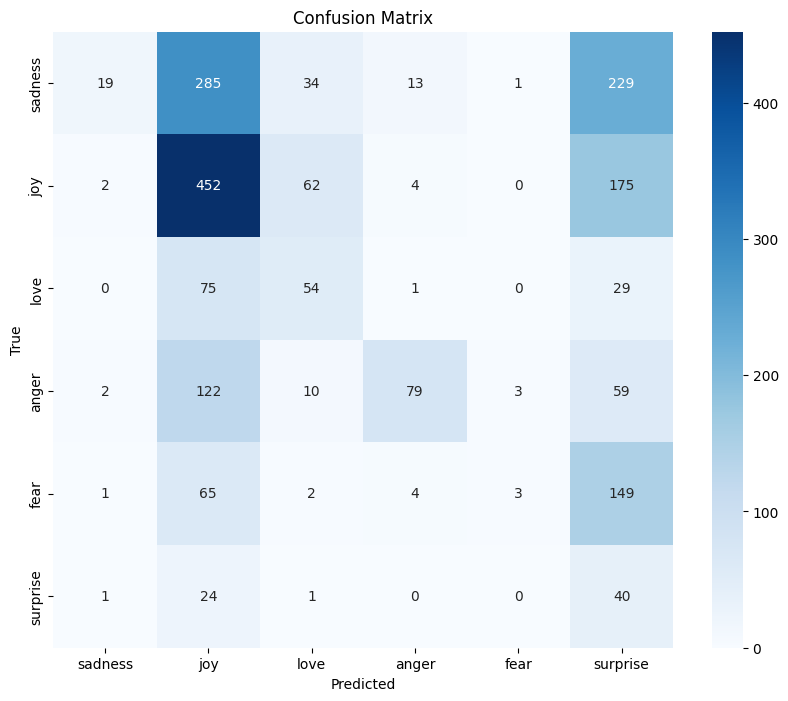

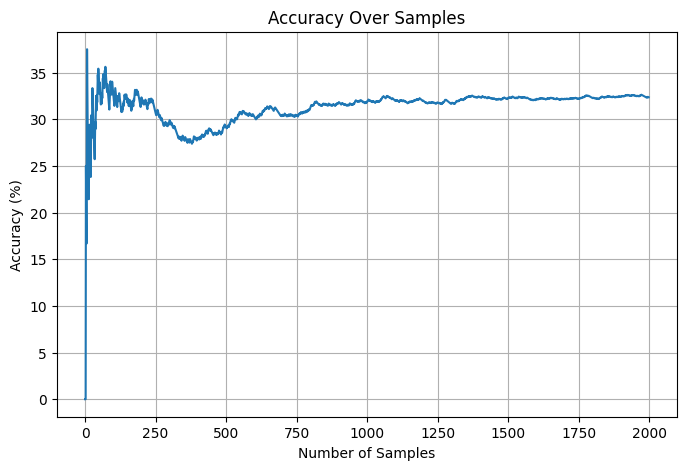

In [ ]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Few-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

### 3-4 examples per emotion

In [ ]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = (f"Choose which emotion this text expresses from the following options: {','.join(emotions)}.\n\n"

              "Text: 'im feel alone and i dont know how to cope'\n"
              "The emotion that best describes this text is: sadness\n\n"
              "Text: 'im feeling rather rotten so im not very ambitious right now'\n"
              "The emotion that best describes this text is: sadness\n\n"
              "Text: 'im updating my blog because i feel shitty'\n"
              "The emotion that best describes this text is: sadness\n\n"
              "Text: 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'\n"
              "The emotion that best describes this text is: sadness\n\n"

              "Text: 'i didnt want to tell him because arun has these single line solutions to all my problems that leave me feeling extremely dissatisfied'\n"
              "The emotion that best describes this text is: anger\n\n"
              "Text: 'i feel really angry sometimes because for the love of god havent we been through enough'\n"
              "The emotion that best describes this text is: anger\n\n"
              "Text: 'i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer'\n"
              "The emotion that best describes this text is: anger\n\n"
              "Text: 'i am feeling grouchy'\n"
              "The emotion that best describes this text is: anger\n\n"

              "Text: 'i just had this feeling that i liked him more'\n"
              "The emotion that best describes this text is: love\n\n"
              "Text: 'ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures'\n"
              "The emotion that best describes this text is: love\n\n"
              "Text: 'ive got a off sale the ad says starting tomorrow but im feeling generous and started it now'\n"
              "The emotion that best describes this text is: love\n\n"

              "Text: 'i watch her silently feeling dazed from my memory loss'\n"
              "The emotion that best describes this text is: surprise\n\n"
              "Text: 'i had a hard time focusing on my life and walked around feeling dazed and confused'\n"
              "The emotion that best describes this text is: surprise\n\n"
              "Text: 'i feel so damn curious with what this blond doctor plan to do this night'\n"
              "The emotion that best describes this text is: surprise\n\n"
              "Text: 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny'\n"
              "The emotion that best describes this text is: surprise\n\n"

              "Text: 'i realized that when i let my mind race and i start to feel restless i get the desire to smoke'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i feel as confused about life as a teenager or as jaded as a year old man'\n"
              "The emotion that best describes this text is: fear\n\n"

              "Text: 'i feel cool calm and collected'\n"
              "The emotion that best describes this text is: joy\n\n"
              "Text: 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'\n"
              "The emotion that best describes this text is: joy\n\n"
              "Text: 'i have to give it to men as women we complain a lot about the heals we have to wear but at least we can wear a dress and feel cool in the summer'\n"
              "The emotion that best describes this text is: joy\n\n"
              "Text: 'i have been with petronas for years i feel that petronas has performed well and made a huge profit'\n"
              "The emotion that best describes this text is: joy\n\n"

              f"Text: '{text}'.\n"
              "The emotion that best describes this text is:"
              )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

print("Sample Results from the Dataset:\n")
for i in range(5):
    review = dataset[i]["text"]
    true_label = dataset[i]["label"]
    predicted_emotion = classify_review(review)
    print(f"Review: {review}")
    print(f"True Emotion: {emotions[true_label]}")  # Convert label to emotion name
    print(f"Classified as: {predicted_emotion}\n")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Sample Results from the Dataset:

Review: im feeling rather rotten so im not very ambitious right now
True Emotion: sadness
Classified as: joy

Review: im updating my blog because i feel shitty
True Emotion: sadness
Classified as: joy

Review: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Emotion: sadness
Classified as: joy

Review: i left with my bouquet o

Few-shot accuracy on the CARER dataset: 35.25%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.72      0.02      0.04       581
         joy       0.41      0.87      0.56       695
        love       0.46      0.14      0.21       159
       anger       0.90      0.13      0.22       275
        fear       0.33      0.00      0.01       224
    surprise       0.07      0.47      0.13        66

    accuracy                           0.35      2000
   macro avg       0.48      0.27      0.20      2000
weighted avg       0.55      0.35      0.26      2000



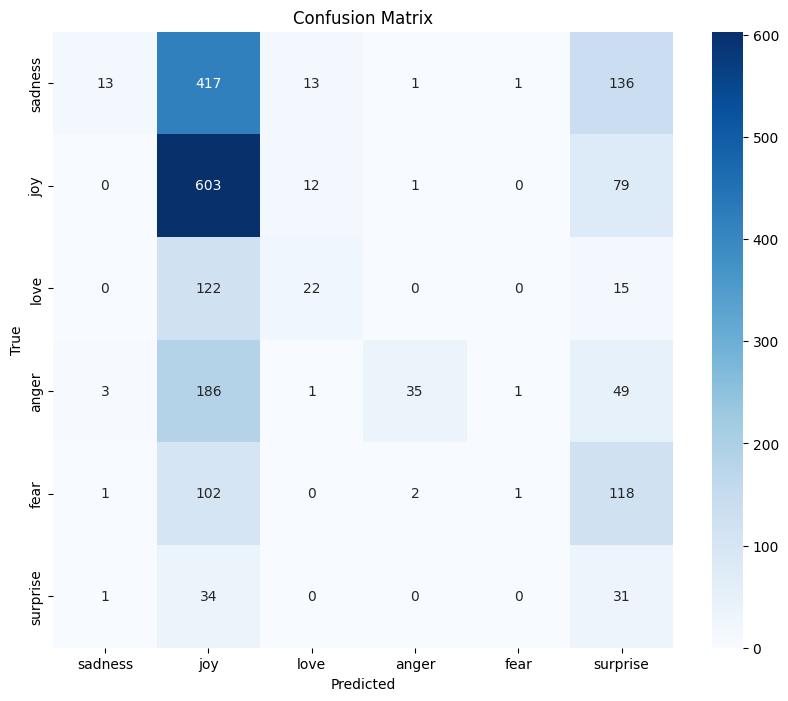

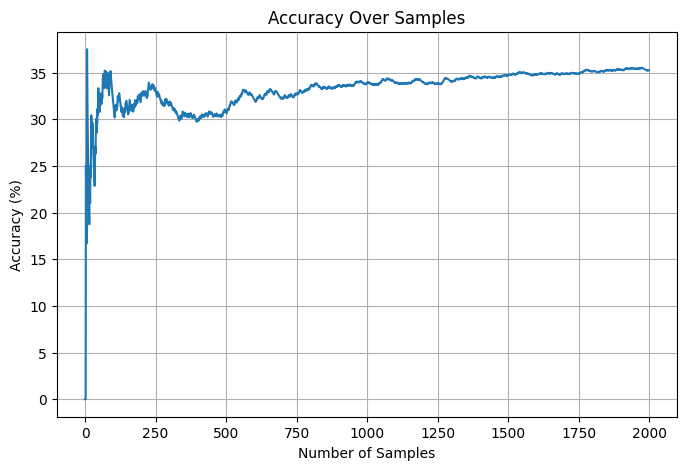

In [ ]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Few-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

### Other tests with additional examples

In [3]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = (f"Choose which emotion this text expresses from the following options: {','.join(emotions)}.\n\n"

              "Text: 'im feel alone and i dont know how to cope'\n"
              "The emotion that best describes this text is: sadness\n\n"
              "Text: 'im feeling rather rotten so im not very ambitious right now'\n"
              "The emotion that best describes this text is: sadness\n\n"
              "Text: 'im updating my blog because i feel shitty'\n"
              "The emotion that best describes this text is: sadness\n\n"

              "Text: 'i didnt want to tell him because arun has these single line solutions to all my problems that leave me feeling extremely dissatisfied'\n"
              "The emotion that best describes this text is: anger\n\n"
              "Text: 'i feel really angry sometimes because for the love of god havent we been through enough'\n"
              "The emotion that best describes this text is: anger\n\n"
              "Text: 'i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer'\n"
              "The emotion that best describes this text is: anger\n\n"

              "Text: 'i just had this feeling that i liked him more'\n"
              "The emotion that best describes this text is: love\n\n"
              "Text: 'ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures'\n"
              "The emotion that best describes this text is: love\n\n"
              "Text: 'ive got a off sale the ad says starting tomorrow but im feeling generous and started it now'\n"
              "The emotion that best describes this text is: love\n\n"
              "Text: 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'\n"
              "The emotion that best describes this text is: love\n\n"

              "Text: 'i watch her silently feeling dazed from my memory loss'\n"
              "The emotion that best describes this text is: surprise\n\n"
              "Text: 'i had a hard time focusing on my life and walked around feeling dazed and confused'\n"
              "The emotion that best describes this text is: surprise\n\n"
              "Text: 'i feel so damn curious with what this blond doctor plan to do this night'\n"
              "The emotion that best describes this text is: surprise\n\n"

              "Text: 'i realized that when i let my mind race and i start to feel restless i get the desire to smoke'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women'\n"
              "The emotion that best describes this text is: fear\n\n"


              # "Text: 'i feel cool calm and collected'\n"
              # "The emotion that best describes this text is: joy\n\n"
              "Text: 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'\n"
              "The emotion that best describes this text is: joy\n\n"
              "Text: 'i have to give it to men as women we complain a lot about the heals we have to wear but at least we can wear a dress and feel cool in the summer'\n"
              "The emotion that best describes this text is: joy\n\n"

              f"Text: '{text}'.\n"
              "The emotion that best describes this text is:"
              )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

print("Sample Results from the Dataset:\n")
for i in range(5):
    review = dataset[i]["text"]
    true_label = dataset[i]["label"]
    predicted_emotion = classify_review(review)
    print(f"Review: {review}")
    print(f"True Emotion: {emotions[true_label]}")  # Convert label to emotion name
    print(f"Classified as: {predicted_emotion}\n")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Sample Results from the Dataset:

Review: im feeling rather rotten so im not very ambitious right now
True Emotion: sadness
Classified as: joy

Review: im updating my blog because i feel shitty
True Emotion: sadness
Classified as: joy

Review: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Emotion: sadness
Classified as: joy

Review: i left with my bouquet o

Few-shot accuracy on the CARER dataset: 33.45%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.81      0.02      0.04       581
         joy       0.43      0.78      0.55       695
        love       0.39      0.19      0.26       159
       anger       0.88      0.16      0.28       275
        fear       0.20      0.00      0.01       224
    surprise       0.06      0.56      0.11        66

    accuracy                           0.33      2000
   macro avg       0.46      0.29      0.21      2000
weighted avg       0.56      0.33      0.27      2000



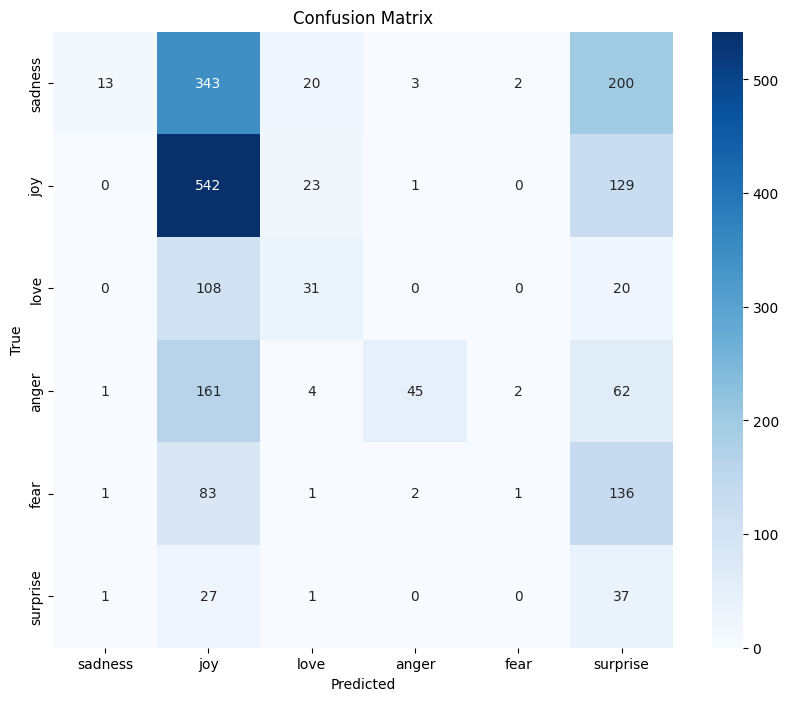

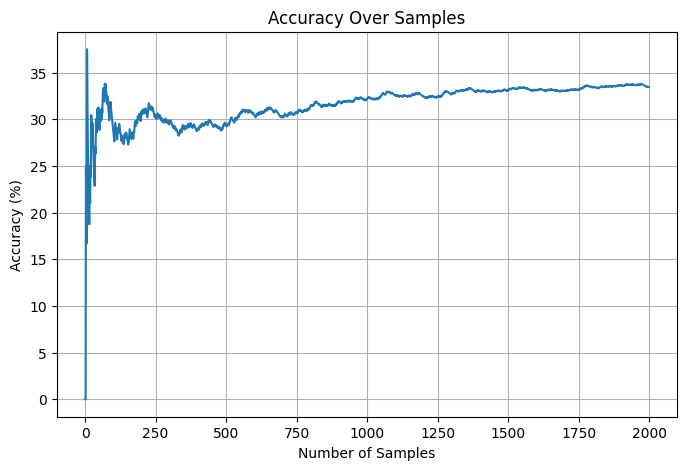

In [4]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Few-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

In [5]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = (f"Choose which emotion this text expresses from the following options: {','.join(emotions)}.\n\n"

              "Text: 'im feel alone and i dont know how to cope'\n"
              "The emotion that best describes this text is: sadness\n\n"
              "Text: 'im feeling rather rotten so im not very ambitious right now'\n"
              "The emotion that best describes this text is: sadness\n\n"
              "Text: 'im updating my blog because i feel shitty'\n"
              "The emotion that best describes this text is: sadness\n\n"
              "Text: 'i am really hurt and i feel unimportant and that sucks'\n"
              "The emotion that best describes this text is: sadness\n\n"

              "Text: 'i didnt want to tell him because arun has these single line solutions to all my problems that leave me feeling extremely dissatisfied'\n"
              "The emotion that best describes this text is: anger\n\n"
              "Text: 'i feel really angry sometimes because for the love of god havent we been through enough'\n"
              "The emotion that best describes this text is: anger\n\n"
              "Text: 'i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer'\n"
              "The emotion that best describes this text is: anger\n\n"

              "Text: 'i just had this feeling that i liked him more'\n"
              "The emotion that best describes this text is: love\n\n"
              "Text: 'ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures'\n"
              "The emotion that best describes this text is: love\n\n"
              "Text: 'ive got a off sale the ad says starting tomorrow but im feeling generous and started it now'\n"
              "The emotion that best describes this text is: love\n\n"
              "Text: 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'\n"
              "The emotion that best describes this text is: love\n\n"

              "Text: 'i watch her silently feeling dazed from my memory loss'\n"
              "The emotion that best describes this text is: surprise\n\n"
              "Text: 'i had a hard time focusing on my life and walked around feeling dazed and confused'\n"
              "The emotion that best describes this text is: surprise\n\n"
              "Text: 'i feel so damn curious with what this blond doctor plan to do this night'\n"
              "The emotion that best describes this text is: surprise\n\n"

              "Text: 'i realized that when i let my mind race and i start to feel restless i get the desire to smoke'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i feel all weird when i have to meet w people i text but like dont talk face to face'\n"
              "The emotion that best describes this text is: fear\n\n"
              "Text: 'i will admit and it left me feeling shaken and a bit of a goose'\n"
              "The emotion that best describes this text is: fear\n\n"


              "Text: 'i feel cool calm and collected'\n"
              "The emotion that best describes this text is: joy\n\n"
              "Text: 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'\n"
              "The emotion that best describes this text is: joy\n\n"
              "Text: 'i have to give it to men as women we complain a lot about the heals we have to wear but at least we can wear a dress and feel cool in the summer'\n"
              "The emotion that best describes this text is: joy\n\n"
              "Text: 'i feel much lighter clearer and more energetic'\n"
              "The eomtion that best describes this text is: joy\n\n"

              f"Text: '{text}'.\n"
              "The emotion that best describes this text is:"
              )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

print("Sample Results from the Dataset:\n")
for i in range(5):
    review = dataset[i]["text"]
    true_label = dataset[i]["label"]
    predicted_emotion = classify_review(review)
    print(f"Review: {review}")
    print(f"True Emotion: {emotions[true_label]}")  # Convert label to emotion name
    print(f"Classified as: {predicted_emotion}\n")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Sample Results from the Dataset:

Review: im feeling rather rotten so im not very ambitious right now
True Emotion: sadness
Classified as: joy

Review: im updating my blog because i feel shitty
True Emotion: sadness
Classified as: joy

Review: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Emotion: sadness
Classified as: joy

Review: i left with my bouquet o

Few-shot accuracy on the CARER dataset: 37.30%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.75      0.02      0.04       581
         joy       0.37      0.99      0.54       695
        love       0.73      0.07      0.13       159
       anger       0.87      0.07      0.13       275
        fear       0.67      0.02      0.03       224
    surprise       0.15      0.17      0.16        66

    accuracy                           0.37      2000
   macro avg       0.59      0.22      0.17      2000
weighted avg       0.60      0.37      0.24      2000



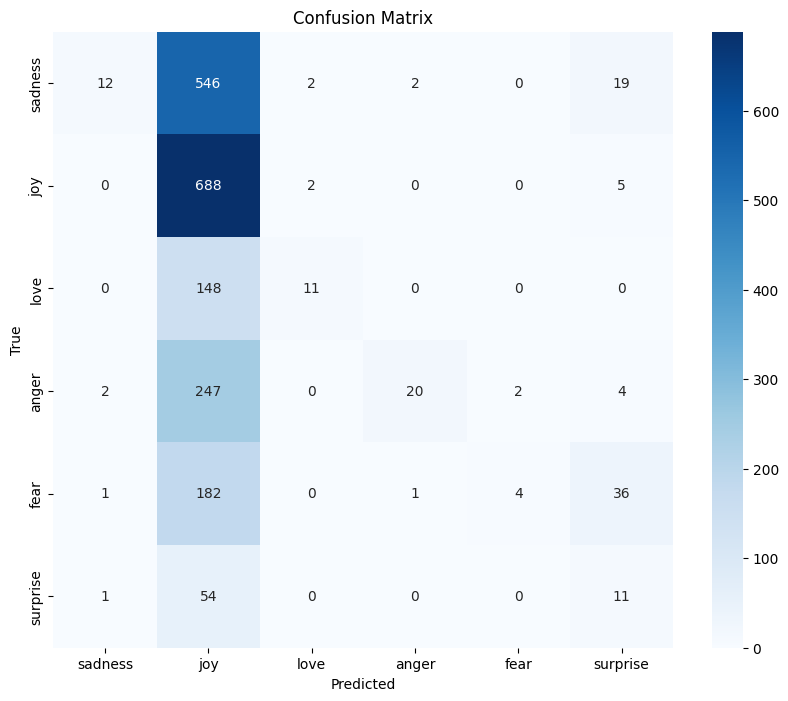

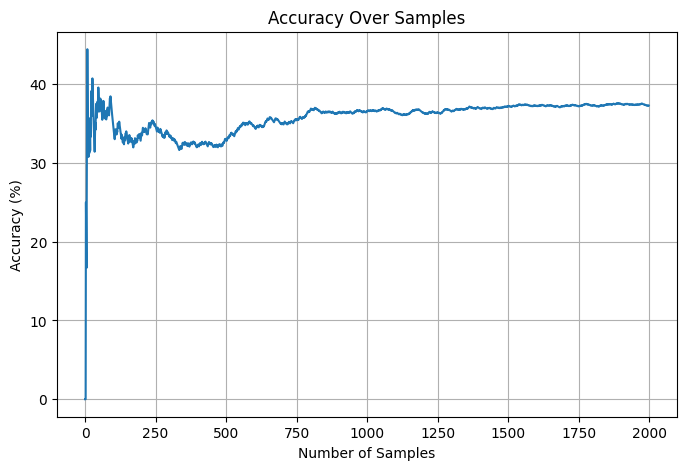

In [6]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Few-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

# GPT-Neo CARER ChatGPT Prompt
This portion of the notebook will prompt a pretrained GPT-Neo on Contextualized Affect Representations for Emotion Recognition (CARER) dataset using prompt generated by ChatGPT.

### One example per emotion

In [5]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = (f"Classify the emotion in this text as one of {', '.join(emotions)}:.\n\n"

              "Text: 'im feel alone and i dont know how to cope'\n"
              "Emotion: sadness\n\n"

              "Text: 'i didnt want to tell him because arun has these single line solutions to all my problems that leave me feeling extremely dissatisfied'\n"
              "Emotion: anger\n\n"

              "Text: 'i just had this feeling that i liked him more'\n"
              "Emotion: love\n\n"

              "Text: 'i had a hard time focusing on my life and walked around feeling dazed and confused'\n"
              "Emotion: surprise\n\n"

              "Text: 'i realized that when i let my mind race and i start to feel restless i get the desire to smoke'\n"
              "Emotion: fear\n\n"

              "Text: 'i feel cool calm and collected'\n"
              "Emotion: joy\n\n"

              f"Text: '{text}'.\n"
              "Emotion:"
              )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

print("Sample Results from the Dataset:\n")
for i in range(5):
    review = dataset[i]["text"]
    true_label = dataset[i]["label"]
    predicted_emotion = classify_review(review)
    print(f"Review: {review}")
    print(f"True Emotion: {emotions[true_label]}")  # Convert label to emotion name
    print(f"Classified as: {predicted_emotion}\n")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Sample Results from the Dataset:

Review: im feeling rather rotten so im not very ambitious right now
True Emotion: sadness
Classified as: sadness

Review: im updating my blog because i feel shitty
True Emotion: sadness
Classified as: love

Review: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Emotion: sadness
Classified as: love

Review: i left with my bou

Few-shot accuracy on the CARER dataset: 10.35%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.61      0.03      0.07       581
         joy       1.00      0.01      0.03       695
        love       0.08      1.00      0.15       159
       anger       1.00      0.06      0.12       275
        fear       0.00      0.00      0.00       224
    surprise       0.33      0.03      0.06        66

    accuracy                           0.10      2000
   macro avg       0.50      0.19      0.07      2000
weighted avg       0.68      0.10      0.06      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


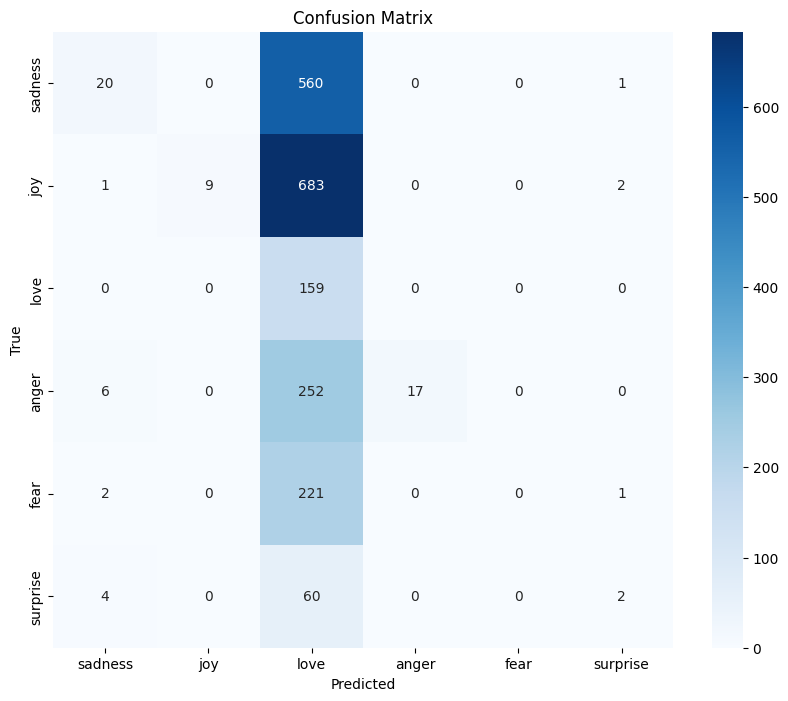

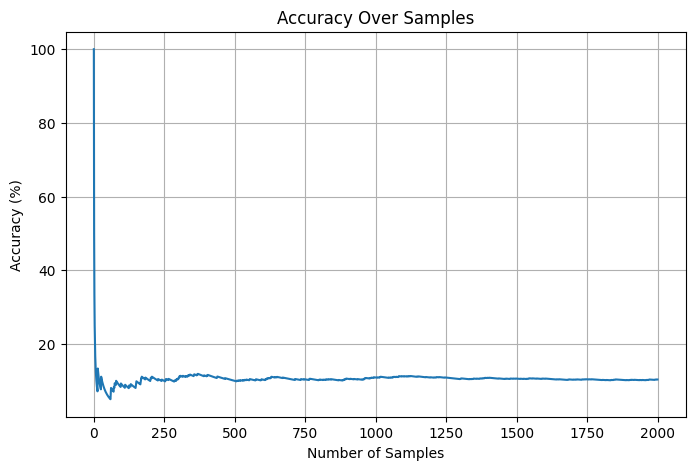

In [6]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Few-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

### Prompting with additionanl examples
About 3-4 examples per emotion

In [7]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = (f"Classify the emotion in this text as one of {', '.join(emotions)}:.\n\n"

              "Text: 'im feel alone and i dont know how to cope'\n"
              "Emotion: sadness\n\n"
              "Text: 'im feeling rather rotten so im not very ambitious right now'\n"
              "Emotion: sadness\n\n"
              "Text: 'im updating my blog because i feel shitty'\n"
              "Emotion: sadness\n\n"
              "Text: 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'\n"
              "Emotion: sadness\n\n"

              "Text: 'i didnt want to tell him because arun has these single line solutions to all my problems that leave me feeling extremely dissatisfied'\n"
              "Emotion: anger\n\n"
              "Text: 'i feel really angry sometimes because for the love of god havent we been through enough'\n"
              "Emotion: anger\n\n"
              "Text: 'i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer'\n"
              "Emotion: anger\n\n"
              "Text: 'i am feeling grouchy'\n"
              "Emotion: anger\n\n"

              "Text: 'i just had this feeling that i liked him more'\n"
              "Emotion: love\n\n"
              "Text: 'ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures'\n"
              "Emotion: love\n\n"
              "Text: 'ive got a off sale the ad says starting tomorrow but im feeling generous and started it now'\n"
              "Emotion: love\n\n"

              "Text: 'i watch her silently feeling dazed from my memory loss'\n"
              "Emotion: surprise\n\n"
              "Text: 'i had a hard time focusing on my life and walked around feeling dazed and confused'\n"
              "Emotion: surprise\n\n"
              "Text: 'i feel so damn curious with what this blond doctor plan to do this night'\n"
              "Emotion: surprise\n\n"
              "Text: 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny'\n"
              "Emotion: surprise\n\n"

              "Text: 'i realized that when i let my mind race and i start to feel restless i get the desire to smoke'\n"
              "Emotion: fear\n\n"
              "Text: 'i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted'\n"
              "Emotion: fear\n\n"
              "Text: 'i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women'\n"
              "Emotion: fear\n\n"
              "Text: 'i feel as confused about life as a teenager or as jaded as a year old man'\n"
              "Emotion: fear\n\n"

              "Text: 'i feel cool calm and collected'\n"
              "Emotion: joy\n\n"
              "Text: 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'\n"
              "Emotion: joy\n\n"
              "Text: 'i have to give it to men as women we complain a lot about the heals we have to wear but at least we can wear a dress and feel cool in the summer'\n"
              "Emotion: joy\n\n"
              "Text: 'i have been with petronas for years i feel that petronas has performed well and made a huge profit'\n"
              "Emotion: joy\n\n"

              f"Text: '{text}'.\n"
              "Emotion:"
              )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

print("Sample Results from the Dataset:\n")
for i in range(5):
    review = dataset[i]["text"]
    true_label = dataset[i]["label"]
    predicted_emotion = classify_review(review)
    print(f"Review: {review}")
    print(f"True Emotion: {emotions[true_label]}")  # Convert label to emotion name
    print(f"Classified as: {predicted_emotion}\n")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Sample Results from the Dataset:

Review: im feeling rather rotten so im not very ambitious right now
True Emotion: sadness
Classified as: joy

Review: im updating my blog because i feel shitty
True Emotion: sadness
Classified as: joy

Review: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Emotion: sadness
Classified as: joy

Review: i left with my bouquet o

Few-shot accuracy on the CARER dataset: 35.55%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.75      0.01      0.01       581
         joy       0.35      0.99      0.52       695
        love       0.56      0.09      0.15       159
       anger       0.67      0.01      0.03       275
        fear       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.36      2000
   macro avg       0.39      0.18      0.12      2000
weighted avg       0.48      0.36      0.20      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


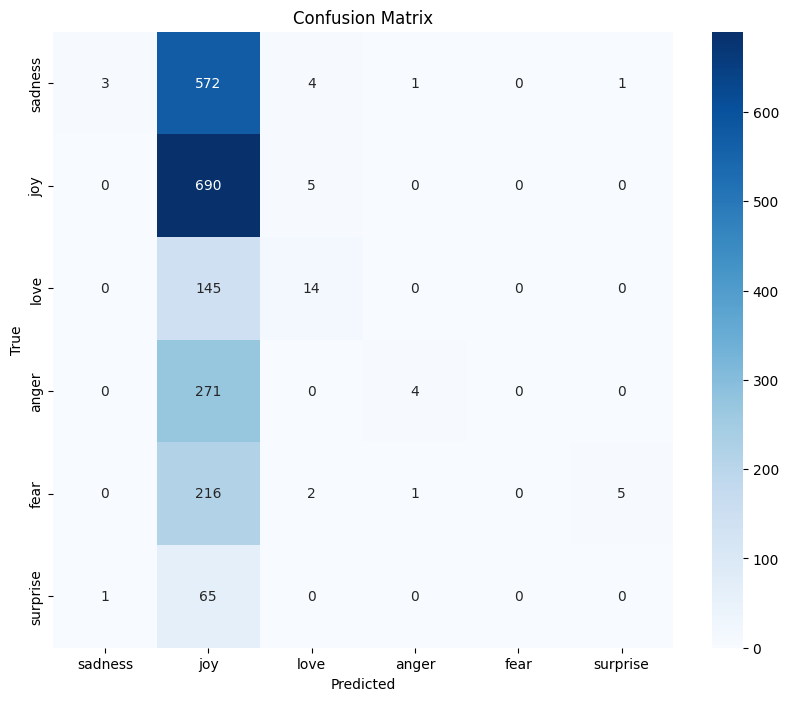

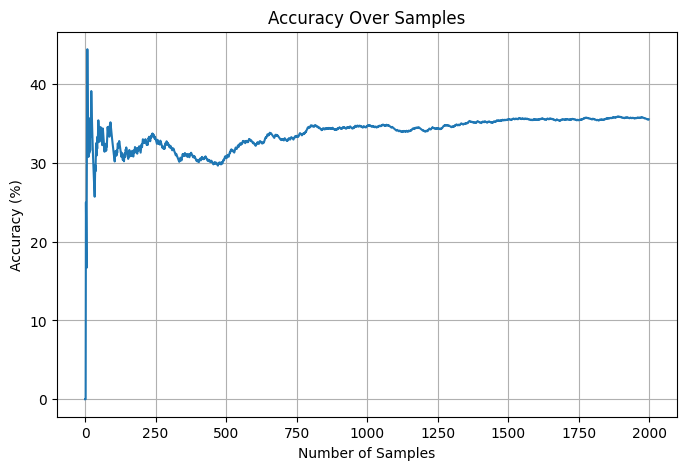

In [8]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Few-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()